# Model Deployment
The purpose of the model deployment phase in a model development process is to take a trained and validated machine learning model and make it available for use in a real-world environment. This phase involves integrating the model into production systems so it can generate predictions on new, unseen data. The main goals are:

- Operationalizing the model so it can be accessed by end-users, applications, or business processes.
- Ensuring the model runs efficiently, reliably, and securely in the target environment.
- Monitoring the model’s performance over time to detect data drift or performance degradation.
- Enabling updates, retraining, or rollback as needed based on new data or requirements.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

In [2]:
version_tag = "dev"

## Load Data And Base Model

In [3]:
## Load data
input_folder = "../.local/analysis_pipeline/data_exploration"
inference_data = pd.read_parquet(f"{input_folder}/inference_data_{version_tag}.parquet")

## Load model
from xgboost import XGBRegressor
input_folder = "../.local/analysis_pipeline/model_selection"
model = XGBRegressor()
model.load_model(f"{input_folder}/xgb_tweedie_model_{version_tag}.json")

## Predict On The Inference Data

In [4]:
# Import xgboost for model prediction (not strictly needed for XGBRegressor, but kept for reference)
import xgboost as xgb

# Define the list of predictor variables (should match those used in model training)
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst

# Select the predictor columns from the inference data
X = inference_data[pred_lst].copy()

# Convert object columns to 'category' dtype if needed (for compatibility, especially if used during training)
for col in pred_lst:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Predict using the loaded XGBRegressor model
pred = model.predict(X)

# Store the predictions in a new column in the inference_data DataFrame
inference_data['xgb_tweedie_pred'] = pred

## Sign risk levels to the quotes

In [5]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck

# Select training samples for predictiveness check
data = inference_data

# Define variables
exp_var = 'veh_cnt'
pred_var = 'xgb_tweedie_pred'
var_1 = 'xgb_tweedie_pred'
var_2 = None
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

# Assign risk bins to quotes in the inference data
pc.binning(nbins=nbins)
processed_inference_data = pc.binned_data

## Inference Via Top Reasons

In [6]:
pred_lst_by_var_imp = ['low_education_ind', 'veh_body', 'credit_score', 'veh_age', 'driving_history_score', 'engine_type', 
                       'veh_color', 'max_power', 'time_driven', 'marital_status', 'veh_value', 'area', 'e_bill', 'agecat', 
                       'gender', 'time_of_week_driven']


--- Predictiveness Plot for low_education_ind ---


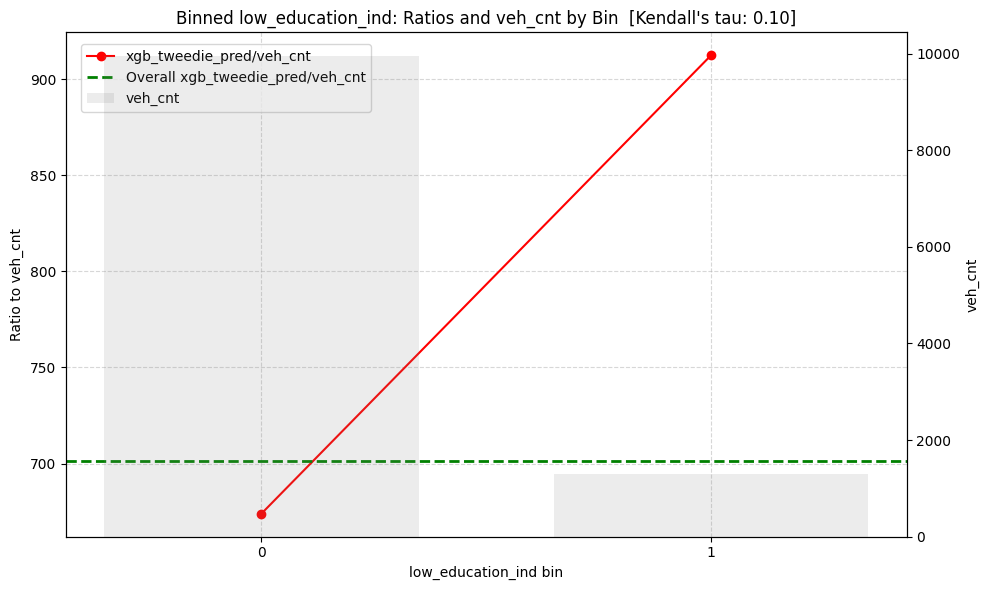


--- Predictiveness Plot for veh_body ---


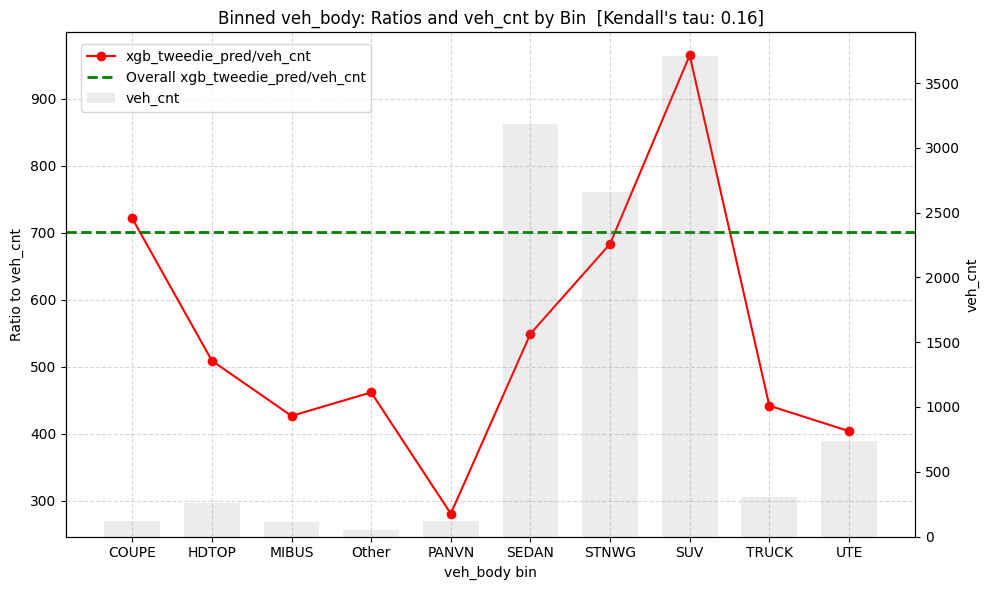


--- Predictiveness Plot for credit_score ---


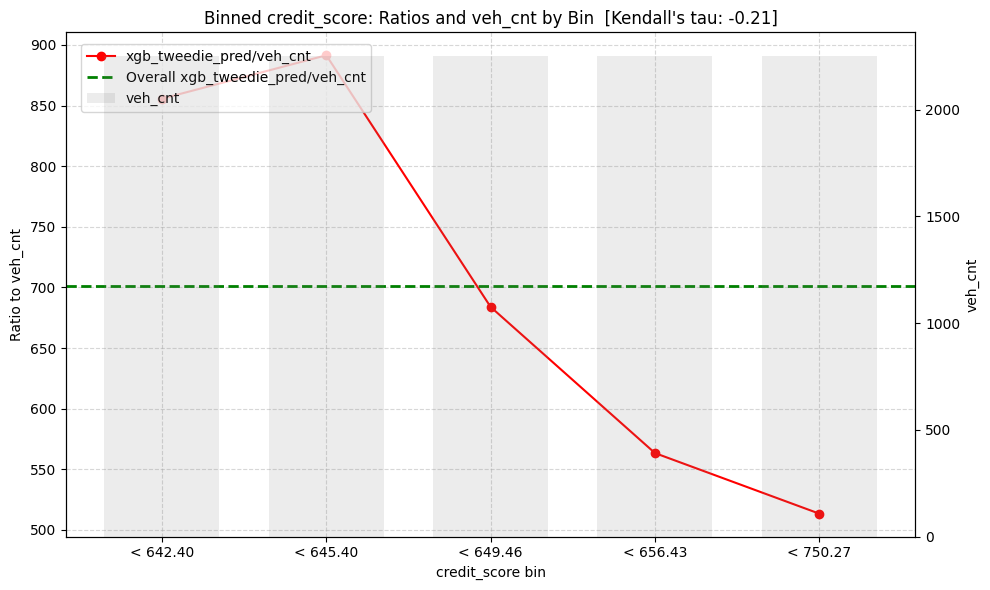


--- Predictiveness Plot for veh_age ---


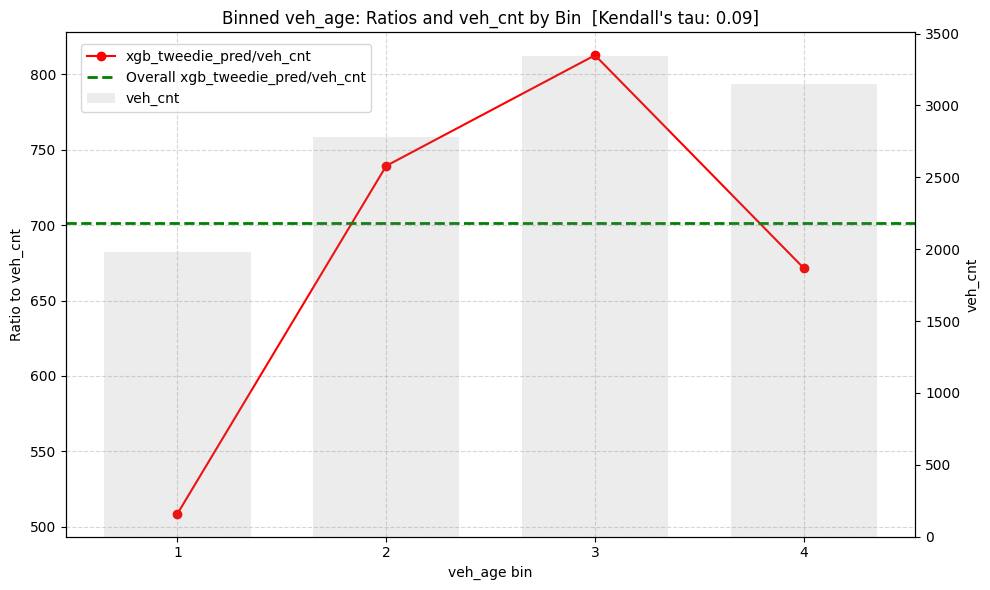


--- Predictiveness Plot for driving_history_score ---


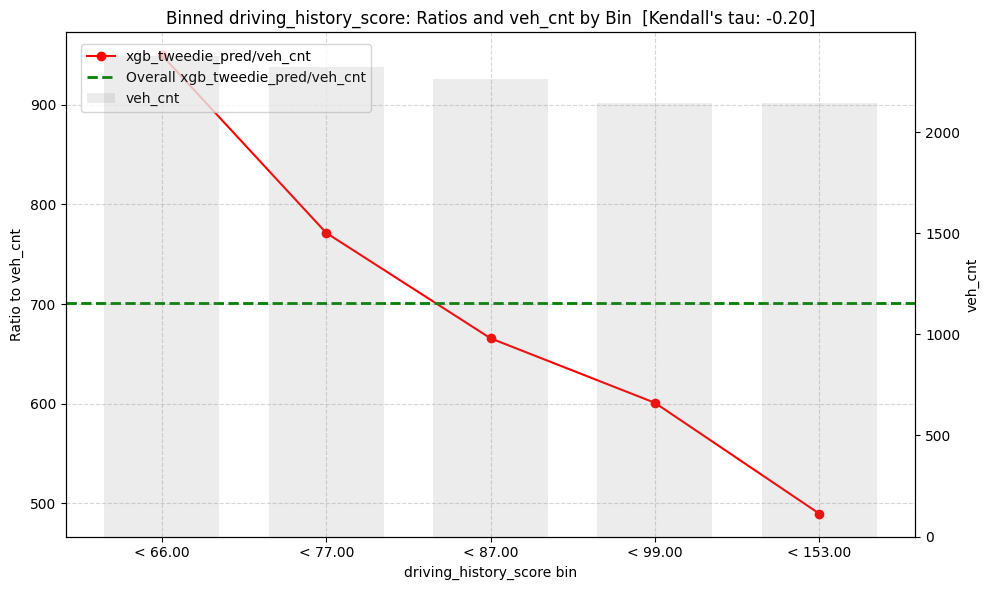


--- Predictiveness Plot for engine_type ---


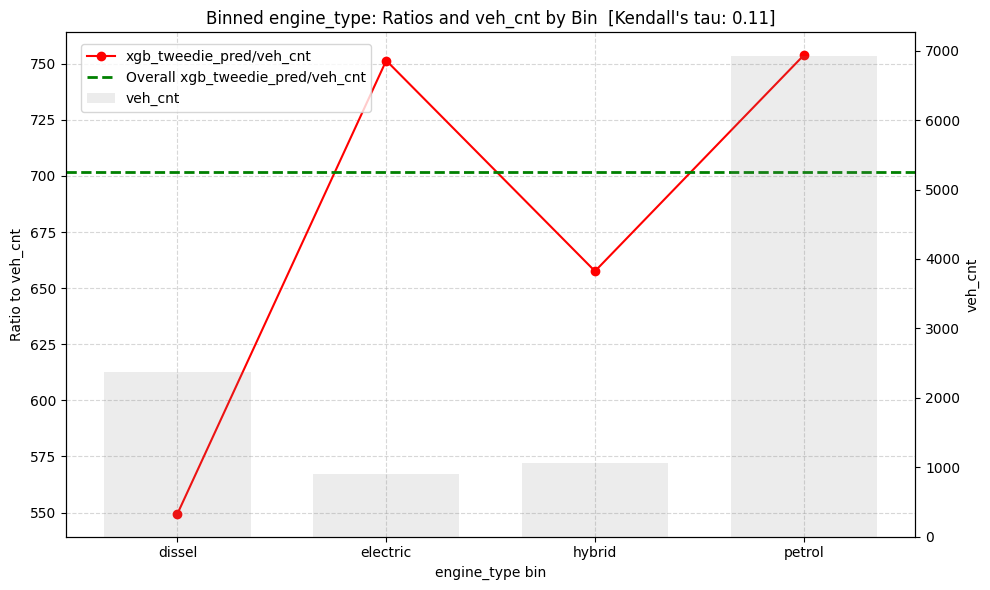


--- Predictiveness Plot for veh_color ---


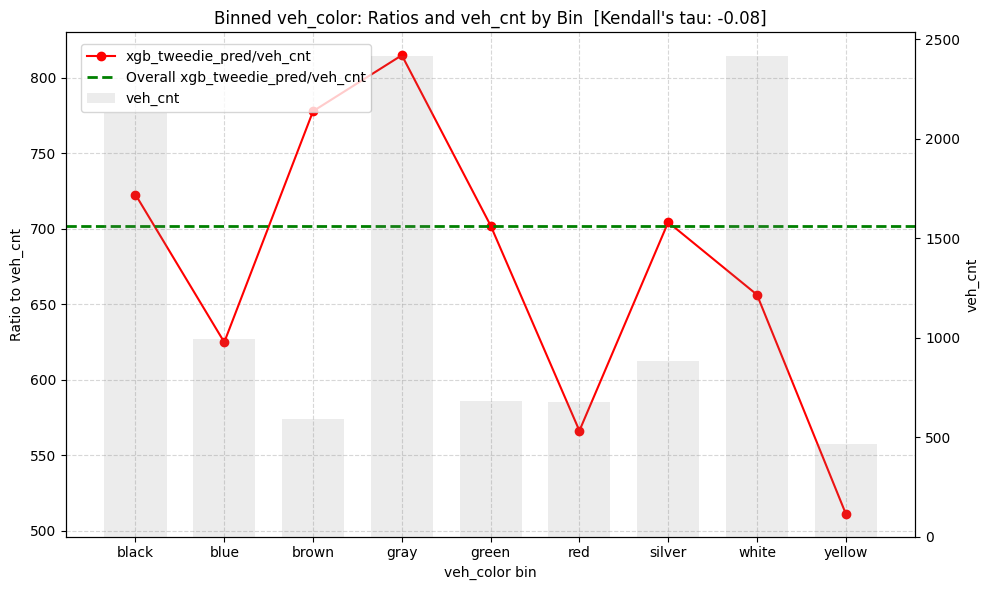


--- Predictiveness Plot for max_power ---


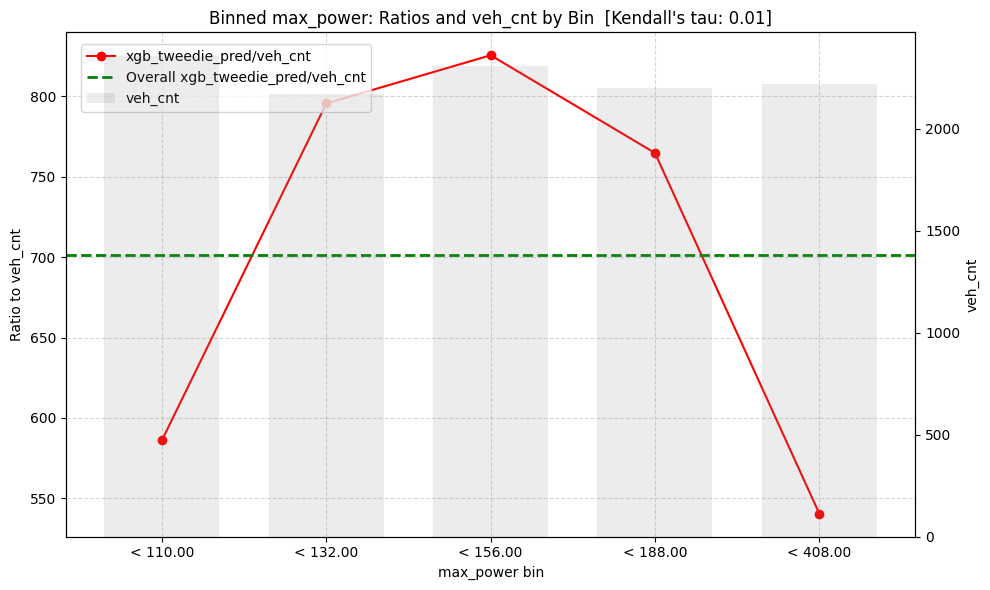


--- Predictiveness Plot for time_driven ---


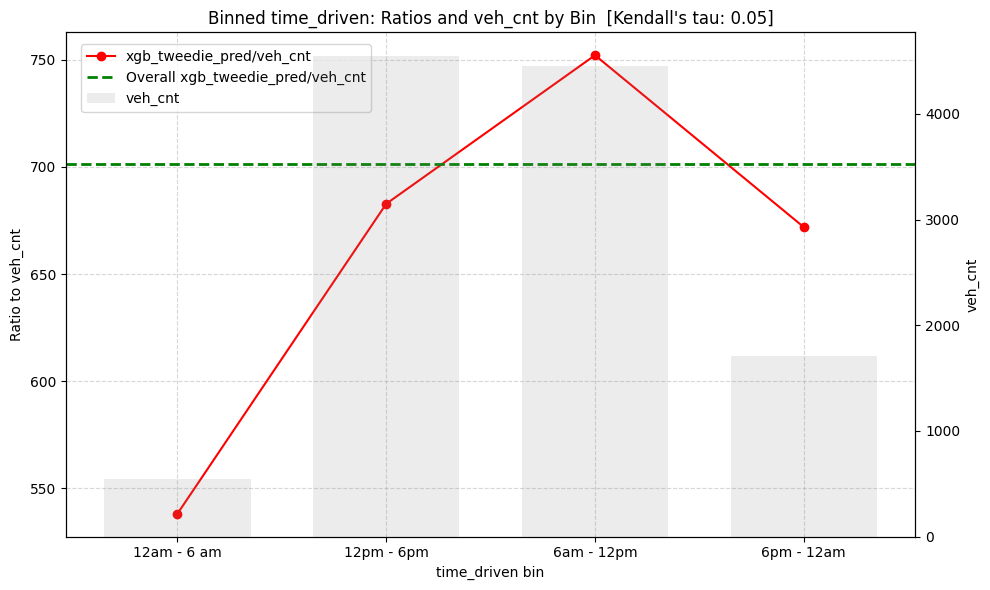


--- Predictiveness Plot for marital_status ---


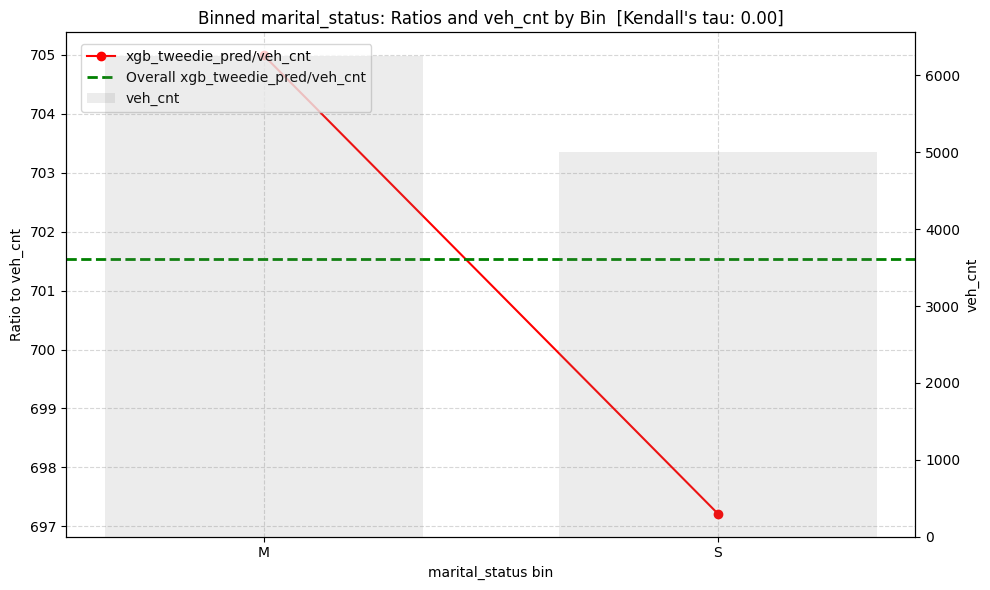


--- Predictiveness Plot for veh_value ---


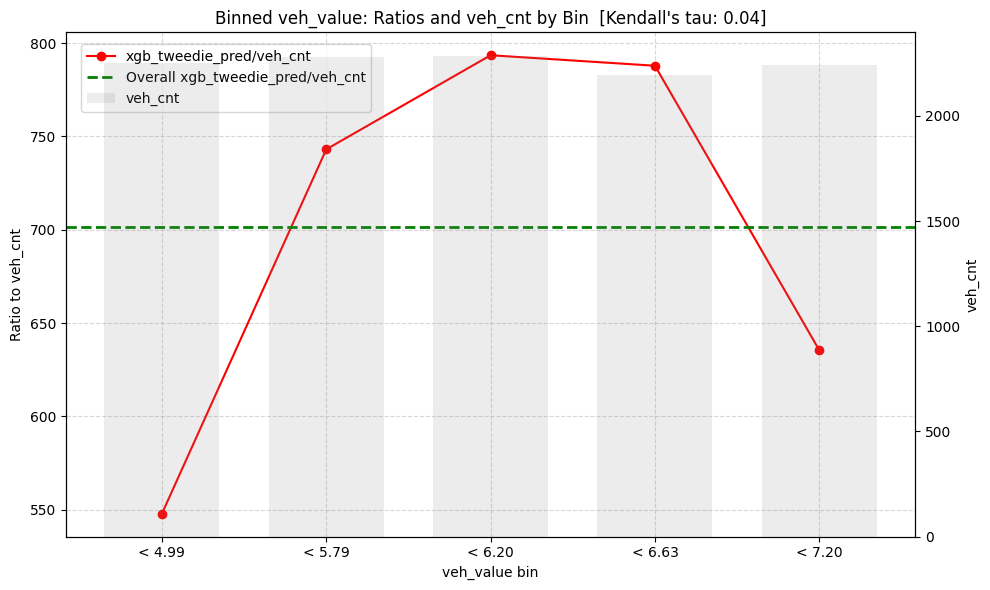


--- Predictiveness Plot for area ---


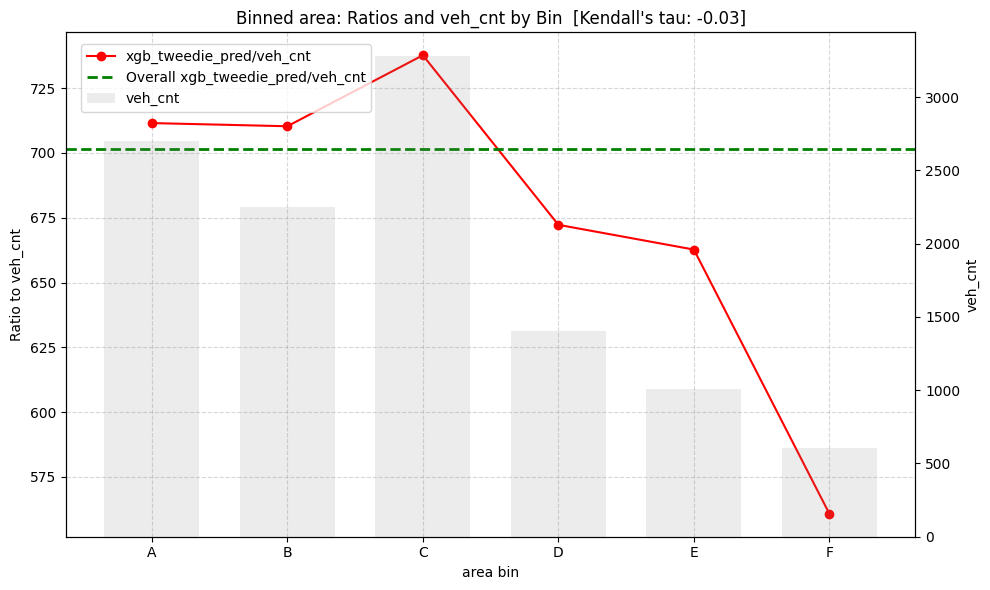


--- Predictiveness Plot for e_bill ---


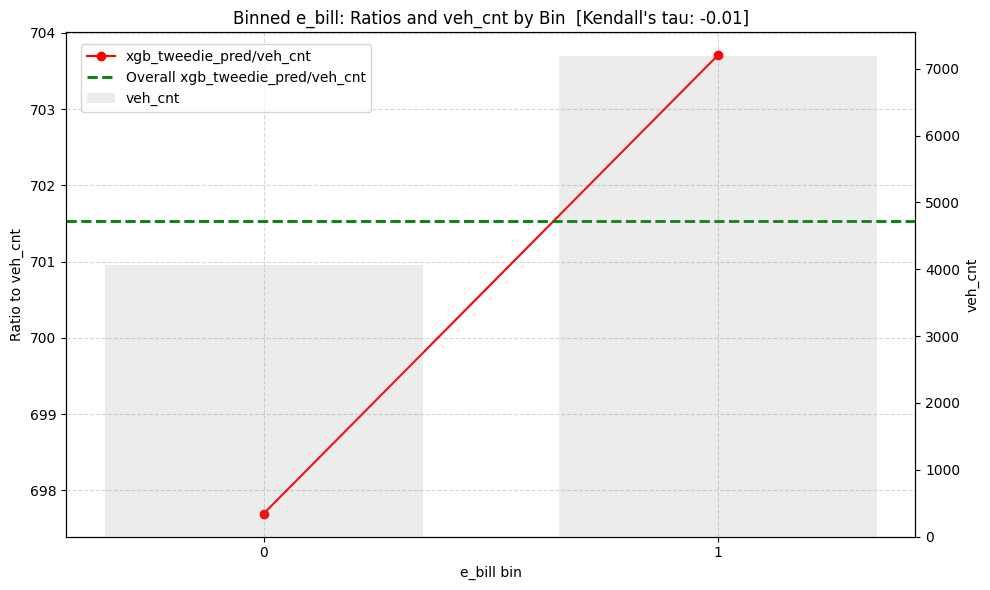


--- Predictiveness Plot for agecat ---


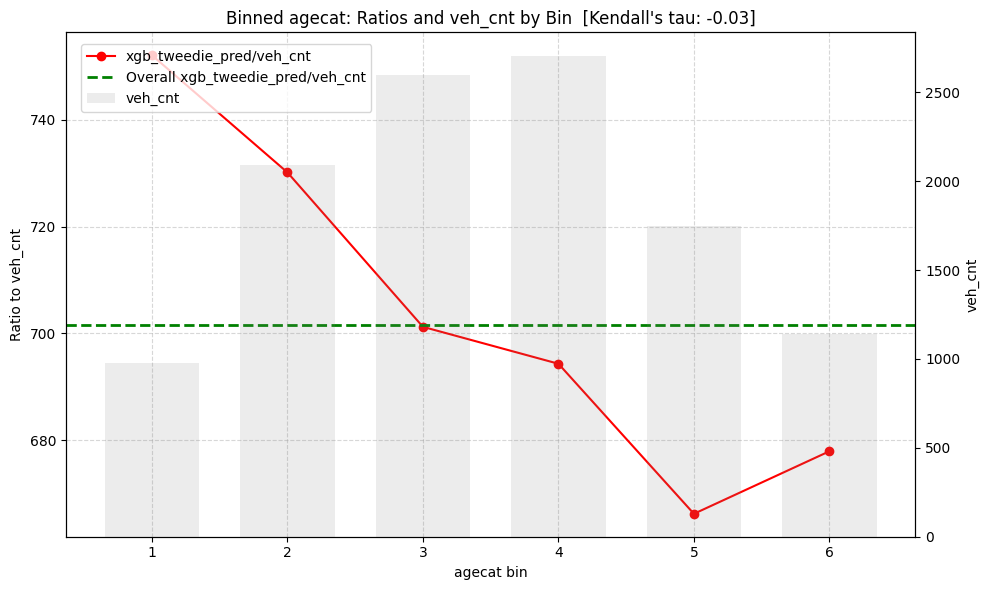


--- Predictiveness Plot for gender ---


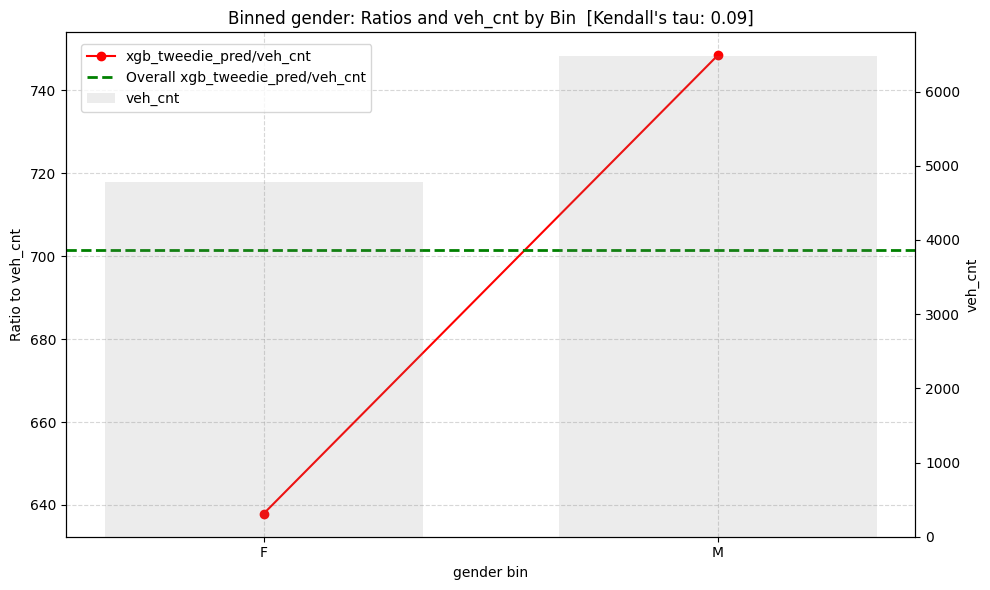


--- Predictiveness Plot for time_of_week_driven ---


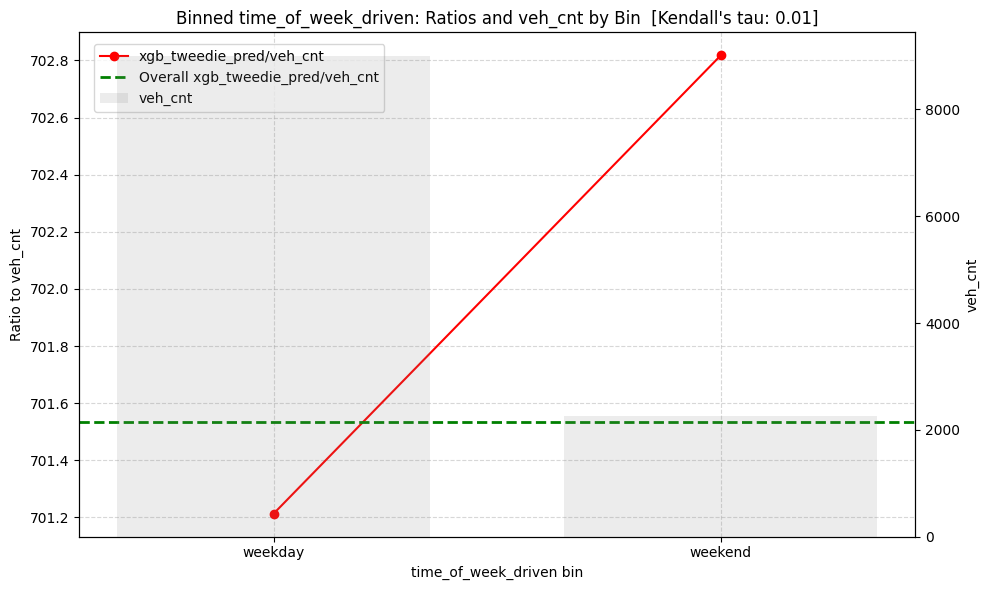

In [7]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
data = processed_inference_data
exp_var = 'veh_cnt' 
var_1 = 'xgb_tweedie_pred'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=data,
    pred_var_lst=pred_lst_by_var_imp,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all(var_1_color='red')

In [8]:
# processed_inference_data.loc[processed_inference_data['bin']==9, :]
processed_inference_data.loc[processed_inference_data['id']==55, :].transpose()

,9764
id,55
veh_value,6.81
exposure,0.233427
veh_body,SUV
veh_age,4
gender,F
area,E
agecat,4
engine_type,hybrid
max_power,152


#### Analysis on id 55
- low_education_ind         = 1         -> <span style="color:red"><b><i>    $100 -> Education level is low                          </i></b></span>
- veh_body                  = SUV       -> <span style="color:red"><b><i>    $150 -> SUV vehicle type                                </i></b></span>
- credit_score              = 646.5     -> <span style="color:green"><b><i>  $-40 -> Credit score is not low                         </i></b></span>
- driving_history_score     = 71        -> <span style="color:red"><b><i>    $120 -> Driving history score is low                    </i></b></span>
- veh_color                 = white     -> <span style="color:red"><b><i>    $ 30 -> Vehicle color is white                          </i></b></span>

<span style="color:red"><b><i>Task 6: Use SHAP values and Waterfall plots to derive top reaons for individual quote and/or global predictor contributions. Specific to-dos are </i></b></span>
1. <span style="color:red"><b><i>Read and summarize the paper: https://arxiv.org/abs/1705.07874.</i></b></span>
2. <span style="color:red"><b><i>Read and try the SHAP value method described in this blog: https://samuel-book.github.io/samuel_shap_paper_1/xgb_10_features/03_xgb_combined_shap_key_features.html. Note that we only need to handle individual case. Global predictor impact session and other sessions are beneficial but not necessary. </i></b></span>